In [2]:
import numpy as np
from pydmd import DMD
import tensorflow as tf

In [3]:
# Import data from data/PSEI.csv to numpy array
# Get only the closing price (usecols=4)
data = np.genfromtxt('data/PSEI.csv', delimiter=',', skip_header=1, usecols=4)
print(f"Length of data: {len(data)}")
print(f"Closing Prices: {data}")

Length of data: 5675
Closing Prices: [2141.77 2153.18 2074.75 ... 6923.08 6842.79 6876.79]


In [4]:
# Split data into training and testing
len_train = int(len(data) * 0.80)
data_train = data[:len_train]
print(f"Length of data_train: {len(data_train)}\nData Train: {data_train}\n")
data_test = data[len_train:]
print(f"Length of data_test: {len(data_test)}\nData Test: {data_test}")

Length of data_train: 4540
Data Train: [2141.77 2153.18 2074.75 ... 7267.34 7348.42 7233.57]

Length of data_test: 1135
Data Test: [7186.71 7186.62 7233.29 ... 6923.08 6842.79 6876.79]


In [5]:
# Create a windowed dataset from the training data (window_size=10)
window_size = 10

train_data = np.zeros((len(data_train) - window_size, window_size))
for i in range(len(data_train) - window_size):
    train_data[i] = data_train[i:i + window_size]
print(f"Shape of train_data: {train_data.shape}\nTrain Data: {train_data}")

Shape of train_data: (4530, 10)
Train Data: [[2141.77 2153.18 2074.75 ... 2101.02 2084.5  2102.1 ]
 [2153.18 2074.75 2079.11 ... 2084.5  2102.1  2097.23]
 [2074.75 2079.11 2094.29 ... 2102.1  2097.23 2074.84]
 ...
 [7312.61 7261.62 7098.15 ... 7066.57 7193.68 7227.96]
 [7261.62 7098.15 7063.2  ... 7193.68 7227.96 7267.34]
 [7098.15 7063.2  6986.88 ... 7227.96 7267.34 7348.42]]


In [8]:
# Find the dynamic modes of the training data
dmd = DMD(svd_rank=1, tlsq_rank=1, exact=True)
dmd.fit(train_data.T)
mode = dmd.modes
print(f"Shape of mode: {mode.shape}\nMode: {mode}")

Shape of mode: (10, 1)
Mode: [[-0.3159506 ]
 [-0.31603756]
 [-0.3161196 ]
 [-0.3161986 ]
 [-0.31627813]
 [-0.31635141]
 [-0.31642433]
 [-0.31649483]
 [-0.31656269]
 [-0.31662868]]


In [19]:
# Set up the model (integrate the dynamic mode)
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(1, input_shape=(window_size,)))
model.layers[0].set_weights([abs(mode), np.zeros(1)])
model.layers[0].trainable = True

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Train the model
model.fit(train_data, data_train[window_size:], epochs=100, verbose=0)

In [20]:
# Predict the next 10 values
pred = model.predict(train_data)
print(f"Shape of pred: {pred.shape}\nPred: {pred}")

142/142 [==============================] - 0s 1ms/step
Shape of pred: (4530, 1)
Pred: [[2112.4578]
 [2110.157 ]
 [2100.9844]
 ...
 [7188.5044]
 [7226.8203]
 [7280.7754]]


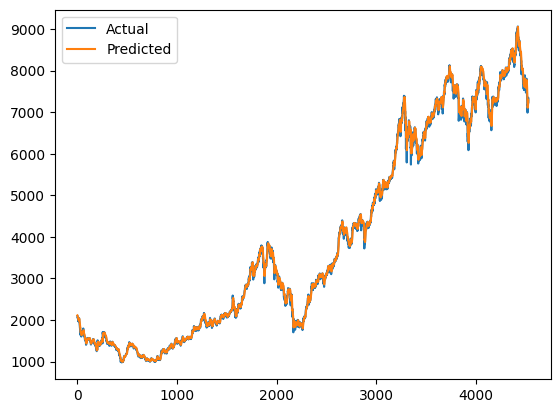

In [21]:
# Plot actual vs predicted
import matplotlib.pyplot as plt

plt.plot(data_train[window_size:], label='Actual')
plt.plot(pred, label='Predicted')
plt.legend()
plt.show()

Shape of test_data: (1125, 10)
Test Data: [[7186.71 7186.62 7233.29 ... 7381.68 7451.37 7387.87]
 [7186.62 7233.29 7333.73 ... 7451.37 7387.87 7399.61]
 [7233.29 7333.73 7350.58 ... 7387.87 7399.61 7376.8 ]
 ...
 [7081.36 7042.7  7052.16 ... 7027.38 6936.61 6881.26]
 [7042.7  7052.16 6970.97 ... 6936.61 6881.26 6923.08]
 [7052.16 6970.97 6793.25 ... 6881.26 6923.08 6842.79]]
36/36 [==============================] - 0s 907us/step
Shape of pred: (1125, 1)
Pred: [[7423.854 ]
 [7427.8057]
 [7421.9604]
 ...
 [6971.0127]
 [6962.9844]
 [6930.9004]]


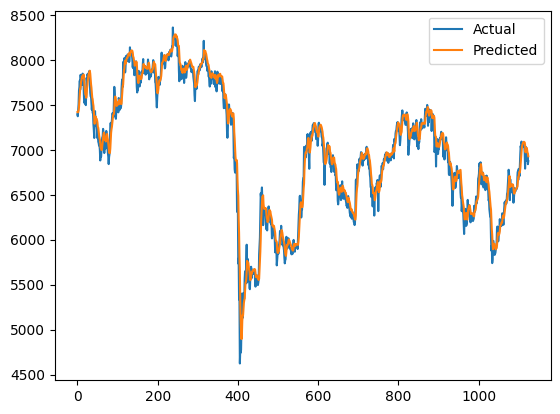

In [22]:
# Predict using the test data
test_data = np.zeros((len(data_test) - window_size, window_size))
for i in range(len(data_test) - window_size):
    test_data[i] = data_test[i:i + window_size]
print(f"Shape of test_data: {test_data.shape}\nTest Data: {test_data}")

pred = model.predict(test_data)
print(f"Shape of pred: {pred.shape}\nPred: {pred}")

# Plot actual vs predicted
plt.plot(data_test[window_size:], label='Actual')
plt.plot(pred, label='Predicted')
plt.legend()
plt.show()

In [23]:
# Test input
test_input = np.array([2.9573, 2.9957, 3.3029, 3.2645, 3.2261, 3.2261, 2.9957, 2.9957, 2.9957,
2.9189])

# Predict the next value
pred = model.predict(test_input.reshape(1, -1))
print(f"Shape of pred: {pred.shape}\nPred: {pred}")

1/1 [==============================] - 0s 20ms/step
Shape of pred: (1, 1)
Pred: [[3.1109188]]
